### Train all Targets within a single Model (Tensorflow)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Dataset/ipage

/content/drive/MyDrive/Dataset/ipage


In [ ]:
!pip install mlflow dagshub --quiet

In [4]:
!pip install Cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 62.5 MB/s eta 0:00:00


#### Utility functions

In [5]:
# Utils

from typing import Any, Literal

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer


def plot_geographical_features(
    df, targets, lat_col="latitude", lon_col="longitude", figsize=(18, 6)
):
    """
    Plot geographical distribution of targets on a map.

    Parameters:
    - df (pd.DataFrame): DataFrame containing data.
    - features (list of str): List of feature column names to plot.
    - lat_col (str): Column name for latitude.
    - lon_col (str): Column name for longitude.
    - figsize (tuple): Figure size.
    """
    # Number of features determines the number of subplots
    num_targets = len(targets)

    # Create subplots
    fig, axes = plt.subplots(
        1, num_targets, figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # Ensure axes is iterable for a single subplot
    if num_targets == 1:
        axes = [axes]

    # Loop through each feature and corresponding axis
    for i, (target, ax) in enumerate(zip(targets, axes)):
        # Add geographical features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=":")
        ax.add_feature(cfeature.LAND, edgecolor="black")
        ax.add_feature(cfeature.LAKES, edgecolor="black")
        ax.add_feature(cfeature.RIVERS, edgecolor="blue")
        ax.add_feature(cfeature.STATES, edgecolor="red")

        # Scatter plot for the feature
        scatter = ax.scatter(
            df[lon_col],
            df[lat_col],
            c=df[target],
            cmap="viridis",
            s=50,
            alpha=0.7,
            transform=ccrs.PlateCarree(),
        )

        # Add a title for each subplot
        ax.set_title(f"{target} Distribution")

        # Add a colorbar for each subplot
        cbar = fig.colorbar(
            scatter, ax=ax, orientation="vertical", shrink=0.7, label=target
        )

    # Add a main title for the figure
    fig.suptitle("Geographical Distribution", fontsize=16)

    # Adjust spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plots
    plt.show()


def get_overfitting_status(val_r2, test_r2):
    """
    Determines the overfitting status based on the difference between validation R² and test R².

    Args:
        val_r2 (float): Validation R² score.
        test_r2 (float): Test R² score.

    Returns:
        tuple: (overfitting_status (str), overfitting_numeric (int))
    """
    diff = abs(val_r2 - test_r2)
    if diff <= 0.02:
        return "Not Overfitting", 0
    elif 0.02 < diff <= 0.06:
        return "Slight Overfitting", 1
    else:
        return "High Overfitting", 2


def categorical_value_counts_to_df(df) -> pd.DataFrame:
    """
    Calculates value counts for each categorical column in a DataFrame and
    returns the results in a new DataFrame.

    Args:
        df: Pandas DataFrame.

    Returns:
        Pandas DataFrame: A DataFrame containing value counts, unique counts,
                         and column names.
    """
    results: list = []
    for column in df.select_dtypes(include=["object"]):
        value_counts: Any = df[column].value_counts()
        unique_count: Any = df[column].nunique()

        for value, count in value_counts.items():
            results.append(
                {
                    "Categorical Feature": column,
                    "Sub-Category": value,
                    "Each Count": count,
                    "Total Unique Count": unique_count,
                }
            )

    return pd.DataFrame(results)


def group_low_frequency_categories(df, threshold=5) -> pd.DataFrame:
    """
    Groups low-frequency categories in all categorical columns of a DataFrame into 'Other'.

    Args:
        df: Pandas DataFrame.
        threshold: The minimum count for a category to be kept as is. Categories with counts
                 less than or equal to this value will be replaced by 'Other'.

    Returns:
        Pandas DataFrame: The modified DataFrame.
    """

    for column in df.select_dtypes(include=["object"]):
        value_counts = df[column].value_counts()
        df[column] = df[column].apply(
            lambda x: x if value_counts[x] > threshold else "Others"
        )
    return df


# Function to calculate the range without outliers
def range_without_outliers(df, feature) -> tuple:
    Q1: Any = df[feature].quantile(0.25)  # First quartile (25th percentile)
    Q3: Any = df[feature].quantile(0.75)  # Third quartile (75th percentile)
    IQR: Any = Q3 - Q1  # Interquartile Range
    lower_bound: Any = Q1 - 1.5 * IQR
    upper_bound: Any = Q3 + 1.5 * IQR

    # Filter out outliers
    filtered_data: Any = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    # Return the range
    min_val: Any = filtered_data[feature].min()
    max_val: Any = filtered_data[feature].max()

    return min_val, max_val


# Function to remove outliers based on IQR
def remove_outliers(df, feature) -> pd.DataFrame:
    # Q1 = df[feature].quantile(0.25)  # First quartile (25th percentile)
    # Q3 = df[feature].quantile(0.75)  # Third quartile (75th percentile)
    Q1: Any = df[feature].quantile(0.05)  # First quartile (5th percentile)
    Q3: Any = df[feature].quantile(0.95)  # Third quartile (95th percentile)
    IQR: Any = Q3 - Q1  # Interquartile Range
    lower_bound: Any = Q1 - 1.5 * IQR
    upper_bound: Any = Q3 + 1.5 * IQR

    # Filter the dataset to include only non-outliers
    df: pd.DataFrame = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df



#### Import necessary libraries

In [6]:
import datetime
import joblib
from pathlib import Path
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

import mlflow
import mlflow.sklearn
import mlflow.keras
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2

# # Import Utility Functions
# from model_utils import classify_skewness, transform_features_for_skewness, transform_targets
# from model_utils import range_without_outliers, remove_outliers
# from model_utils import SkewnessTransformer
# from model_utils import categorical_value_counts_to_df, group_low_frequency_categories
# from model_utils import plot_geographical_features
# from model_utils import get_overfitting_status
import random

import warnings
warnings.filterwarnings("ignore")

#### Columns To Drop

In [7]:
# COLS_TO_DROP = ["longitude", "latitude"]
COLS_TO_DROP = ["longitude", "latitude", "Soil group", "Land class", "Soil type"]

#### Hyperparameters and Other definitions

In [8]:
TIME_FORMAT = "%Y%m%d"
CURRENT_TIME = datetime.datetime.now().strftime(TIME_FORMAT)

# L1_FACTOR: float = 0.01
L1_FACTOR_BORON: float = 0.001
L1_FACTOR_ZINC: float = 0.01
L1_FACTOR_SOC: float = 0.01

L2_FACTOR: float = 0.01
UPDATE_RATE: float = 0.001
MAX_L1_FACTOR: float = 0.02
PATIENCE: int = 10
PATIENCE_FOR_L1: int = 3
RESTORE_BEST_WEIGHTS: bool = True
EPOCHS: int = 100
BATCH_SIZE: int = 32

POWER_TRANSFORMER_METHOD: str = "yeo-johnson"
TRAIN_SIZE: float = 0.7
TEST_SIZE: float = 0.2
VAL_SIZE: float = 0.1

# SELECTED_TARGET = "Boron"
ALL_TARGETS = ["Boron", "Zinc", "SOC"]

DATASET_VERSION: str = "v3" # using the version 3, v3 dataset
MODEL_SAVE_PATH: str = f"./checkpoints/tf_all_targets_model/"

# Make dir if it doesn't exist
Path(MODEL_SAVE_PATH).mkdir(parents=True, exist_ok=True)
# Path(BEST_MODEL_SUMMARY_CSV_PATH).mkdir(parents=True, exist_ok=True)

In [9]:
# Set random seed for reproducibility
# seeds: list[int] = [42, 101, 2023, 7, 99]
RANDOM_STATE: int = 101

In [10]:
APPLY_DYNAMIC_LI_REG: bool = True

In [11]:
print(f"Dynamic L1: {APPLY_DYNAMIC_LI_REG}")
print(f"Seed: {RANDOM_STATE}")

Dynamic L1: True
Seed: 101


In [12]:
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

#### Load Dataset

In [13]:
file_path = f"merged_{DATASET_VERSION}.csv"
# Create a Path object
data_file_path = Path(file_path)
data = pd.read_csv(data_file_path)

df = data.copy()

In [14]:
df.head()

,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
0,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,33.0
1,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,33.0
2,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,33.0
3,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00,33.0,33.0,33.0
4,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04,33.0,33.0,33.0


In [15]:
length_df = len(df)
print(f"Length of Dataset: {length_df}")

Length of Dataset: 2584


In [16]:
df.describe()

,longitude,latitude,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,22.979895,12.711743,5.869107,1.002453,0.070375,0.238226,8.586086,8.843246,0.113593,1.187543,56.202786,22.819659,20.175310
std,31.597277,6.212016,0.518722,0.626685,0.039282,0.140441,9.266400,5.267589,0.132118,0.470586,10.998711,7.472131,5.535707
min,4.430300,8.039070,4.100000,0.100000,0.000800,0.000000,0.060000,0.650000,0.001611,0.080000,20.000000,10.000000,10.000000
25%,6.972760,9.251048,5.536365,0.553925,0.040000,0.138462,3.664697,5.668802,0.024444,0.879671,51.000000,18.000000,16.000000
50%,8.617840,9.971485,5.913315,0.807029,0.062176,0.209134,5.714590,7.243420,0.060213,1.143550,58.000000,20.000000,20.000000
75%,10.430405,11.159215,6.226348,1.290080,0.092213,0.313721,9.579792,10.298875,0.154269,1.443010,64.000000,24.000000,22.000000
max,89.416700,25.850000,7.945400,4.480000,0.257264,0.990000,74.500000,39.700000,0.990000,4.000000,80.000000,40.000000,60.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longitude   2584 non-null   float64
 1   latitude    2584 non-null   float64
 2   Area        2584 non-null   object 
 3   Soil group  2584 non-null   object 
 4   Land class  2584 non-null   object 
 5   Soil type   2584 non-null   object 
 6   pH          2584 non-null   float64
 7   SOC         2584 non-null   float64
 8   Nitrogen    2584 non-null   float64
 9   Potassium   2584 non-null   float64
 10  Phosphorus  2584 non-null   float64
 11  Sulfur      2584 non-null   float64
 12  Boron       2584 non-null   float64
 13  Zinc        2584 non-null   float64
 14  Sand        2584 non-null   float64
 15  Silt        2584 non-null   float64
 16  Clay        2584 non-null   float64
dtypes: float64(13), object(4)
memory usage: 343.3+ KB


In [18]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())
print("\n")
print(df.isnull().sum())

False
0


longitude     0
latitude      0
Area          0
Soil group    0
Land class    0
Soil type     0
pH            0
SOC           0
Nitrogen      0
Potassium     0
Phosphorus    0
Sulfur        0
Boron         0
Zinc          0
Sand          0
Silt          0
Clay          0
dtype: int64


In [19]:
# Check for duplicates
duplicates = df.duplicated()
print(duplicates.sum())

0


#### Drop Columns

In [20]:
df.drop(COLS_TO_DROP, axis=1, inplace=True)
df.describe()

,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,5.869107,1.002453,0.070375,0.238226,8.586086,8.843246,0.113593,1.187543,56.202786,22.819659,20.175310
std,0.518722,0.626685,0.039282,0.140441,9.266400,5.267589,0.132118,0.470586,10.998711,7.472131,5.535707
min,4.100000,0.100000,0.000800,0.000000,0.060000,0.650000,0.001611,0.080000,20.000000,10.000000,10.000000
25%,5.536365,0.553925,0.040000,0.138462,3.664697,5.668802,0.024444,0.879671,51.000000,18.000000,16.000000
50%,5.913315,0.807029,0.062176,0.209134,5.714590,7.243420,0.060213,1.143550,58.000000,20.000000,20.000000
75%,6.226348,1.290080,0.092213,0.313721,9.579792,10.298875,0.154269,1.443010,64.000000,24.000000,22.000000
max,7.945400,4.480000,0.257264,0.990000,74.500000,39.700000,0.990000,4.000000,80.000000,40.000000,60.000000


#### Drop raw longitude and latitude if present

#### Define target variable and features

In [21]:
targets = ["Boron", "Zinc", "SOC"]
features = [col for col in df.columns if col not in targets]

In [22]:
print(f"Target: {targets}")
print(f"Features: {features}")

Target: ['Boron', 'Zinc', 'SOC']
Features: ['Area', 'pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']


#### Identify categorical and numerical features

In [23]:
categorical_features = df[features].select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df[features].select_dtypes(include=['number']).columns.tolist()

In [24]:
print(f"Categorical Features:\n {categorical_features}\n")
print(f"Numerical Features:\n {numerical_features}\n")

Categorical Features:
 ['Area']

Numerical Features:
 ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']



#### 1. Analyze Ccategorical_features

In [25]:
print(f"Unique Values in 'Area' col:\n {df['Area'].unique()}\n")
print("-" * 120)
# print(f"Unique Values in 'Soil group' col:\n {df['Soil group'].unique()}\n")
# print("*" * 120)
# print(f"Unique Values in 'Land class' col\n: {df['Land class'].unique()}\n")
# print("*" * 120)
# print(f"Unique Values in 'Soil type' col\n: {df['Soil type'].unique()}\n")

Unique Values in 'Area' col:
 ['Mithpukur' 'Pirgacha ' 'Gangachara' 'Kaunia upazila' 'Taraganj Thana'
 'Bauchi' 'Taraba' 'Plateau' 'Kaduna' 'Nasarawa' 'Niger' 'Kebbi' 'Kano'
 'Kwara' 'Katsina' 'Adamawa']

------------------------------------------------------------------------------------------------------------------------


In [26]:
# Get the value counts in Categorical Columns of DataFrame
counts_df = categorical_value_counts_to_df(df)
# Print the resulting DataFrame
print(f"Categorical Value Counts")
print("-" * 24, "\n")
# print(counts_df)
counts_df

Categorical Value Counts
------------------------ 



,Categorical Feature,Sub-Category,Each Count,Total Unique Count
0,Area,Niger,561,16
1,Area,Kaduna,402,16
2,Area,Plateau,359,16
3,Area,Bauchi,226,16
4,Area,Nasarawa,215,16
5,Area,Mithpukur,186,16
6,Area,Taraba,135,16
7,Area,Pirgacha,125,16
8,Area,Katsina,81,16
9,Area,Taraganj Thana,79,16


In [27]:
# Group low frequency categories
df = group_low_frequency_categories(df, threshold=5)

##### 4. Remove Outliers

In [28]:
# Dynamically apply the function to each numerical feature
for feature in numerical_features:
    df = remove_outliers(df, feature)

length_df_remove_outliers = len(df)
print(f"Length of Dataset After Removal of Ouliers")
print("-"* 42)
print(length_df_remove_outliers)

# Print the cleaned dataset
print("\nDataset after removing outliers:")
print("-"* 32, "\n")
df.describe().T

Length of Dataset After Removal of Ouliers
------------------------------------------
2572

Dataset after removing outliers:
-------------------------------- 



,count,mean,std,min,25%,50%,75%,max
pH,2572.0,5.872734,0.516360,4.100000,5.544477,5.918895,6.227370,7.945400
SOC,2572.0,0.999961,0.626380,0.100000,0.552021,0.803703,1.284992,4.480000
Nitrogen,2572.0,0.070295,0.039317,0.000800,0.040000,0.062087,0.092144,0.257264
Potassium,2572.0,0.238257,0.140553,0.000000,0.137771,0.209207,0.313721,0.990000
Phosphorus,2572.0,8.309131,8.348160,0.060000,3.657857,5.703735,9.403460,62.900000
Sulfur,2572.0,8.804159,5.227483,0.650000,5.660660,7.236340,10.217925,39.700000
Boron,2572.0,0.112374,0.130301,0.001611,0.024301,0.059704,0.153684,0.990000
Zinc,2572.0,1.189048,0.470255,0.080000,0.880000,1.145280,1.443835,4.000000
Sand,2572.0,56.286547,10.953631,20.000000,52.000000,58.000000,64.000000,80.000000
Silt,2572.0,22.747667,7.411745,10.000000,18.000000,20.000000,24.000000,40.000000


##### 5. Correlation

In [29]:
df_corr = df[numerical_features + targets].corr()
# df_corr

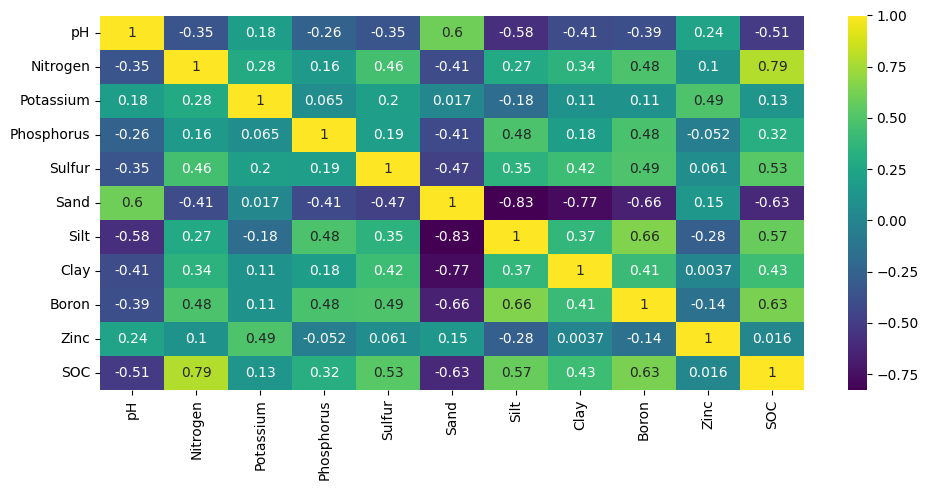

In [30]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_corr, annot=True, cmap='viridis')
# plt.ylim(10, 0)
plt.tight_layout()
plt.show()

#### Dataset split

In [31]:
print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features: ['Area']
Numerical Features: ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']


In [32]:
# Coluumns to Drop for Dummies
COLS_TO_DROP_DUMMIES = ["Area"]

In [33]:
area_dummies = pd.get_dummies(df[COLS_TO_DROP_DUMMIES[0]], drop_first=True)
df = pd.concat([df.drop(COLS_TO_DROP_DUMMIES[0], axis=1), area_dummies], axis=1)
df.columns

Index(['pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Boron',
       'Zinc', 'Sand', 'Silt', 'Clay', 'Gangachara', 'Kaduna', 'Kano',
       'Katsina', 'Kaunia upazila', 'Kebbi', 'Mithpukur', 'Nasarawa', 'Niger',
       'Others', 'Pirgacha ', 'Plateau', 'Taraba', 'Taraganj Thana'],
      dtype='object')

In [34]:
df.head(3)

,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,...,Kaunia upazila,Kebbi,Mithpukur,Nasarawa,Niger,Others,Pirgacha,Plateau,Taraba,Taraganj Thana
0,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
1,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
2,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False


In [35]:
# Update Features, Cacategorical_features, Numerical Features
features = [col for col in df.columns if col not in targets]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
boolean_features = df.select_dtypes(include=['boolean']).columns.tolist()

print(f"Updated Features: {features}")
print(f"Updated Numerical Features: {numerical_features}")
print(f"Updated Categorical Features: {categorical_features}")
print(f"Updated Bolean_features Features: {boolean_features}")

Updated Features: ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay', 'Gangachara', 'Kaduna', 'Kano', 'Katsina', 'Kaunia upazila', 'Kebbi', 'Mithpukur', 'Nasarawa', 'Niger', 'Others', 'Pirgacha ', 'Plateau', 'Taraba', 'Taraganj Thana']
Updated Numerical Features: ['pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Boron', 'Zinc', 'Sand', 'Silt', 'Clay']
Updated Categorical Features: []
Updated Bolean_features Features: ['Gangachara', 'Kaduna', 'Kano', 'Katsina', 'Kaunia upazila', 'Kebbi', 'Mithpukur', 'Nasarawa', 'Niger', 'Others', 'Pirgacha ', 'Plateau', 'Taraba', 'Taraganj Thana']


In [36]:
# X = df[numerical_features + categorical_features]  # Full feature set
X = df[numerical_features + categorical_features + boolean_features]
# y = pd.DataFrame(df[targets][SELECTED_TARGET])  # Target variables
y = pd.DataFrame(df[targets][ALL_TARGETS])  # Target variables
# Convert y DataFrame to a 1D NumPy array
# y = y.values.ravel()  # Shape changes from e.g (2572, 1) to (2572,) #
# y = y.values

In [37]:
X.head(3)

,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,...,Kaunia upazila,Kebbi,Mithpukur,Nasarawa,Niger,Others,Pirgacha,Plateau,Taraba,Taraganj Thana
0,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
1,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
2,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False


In [38]:
print(f"X Shape: {X.shape}")
print(f"X Type: {type(X)}")

print(f"y Shape: {y.shape}")
print(f"y Type: {type(y)}")

X Shape: (2572, 25)
X Type: <class 'pandas.core.frame.DataFrame'>
y Shape: (2572, 3)
y Type: <class 'pandas.core.frame.DataFrame'>


#### Split data into train, Val and test sets

In [39]:
# First split: Train + Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=(1 - TRAIN_SIZE),
    random_state=RANDOM_STATE,
    # stratify=y
)

# Second split: Validation + Test from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)),
    random_state=RANDOM_STATE,
    # stratify=y_temp
)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (1800, 25), Validation Set: (257, 25), Test Set: (515, 25)


#### Apply Scaling

In [40]:
# Step 2: Scale the data using MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler() # I used standard scaler

# Fit the scaler only on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Define Models

In [41]:
## Callback Class

# Define a custom L1 regularizer that supports both static and dynamic L1
class FlexibleL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, l1_factor, is_dynamic=False):
        """
        Flexible L1 Regularizer that supports both dynamic and static L1 factors.

        Args:
        - l1_factor (float or tf.Variable): L1 regularization factor.
        - is_dynamic (bool): Whether to apply dynamic regularization using a tf.Variable.
        """
        self.l1_factor = tf.Variable(l1_factor, trainable=False, dtype=tf.float32) if is_dynamic else l1_factor
        self.is_dynamic = is_dynamic

    def __call__(self, x):
        if self.is_dynamic:
            return tf.reduce_sum(self.l1_factor * tf.abs(x))
        return tf.reduce_sum(self.l1_factor * tf.abs(x))

    def get_config(self):
        return {"l1_factor": self.l1_factor.numpy() if self.is_dynamic else self.l1_factor}


class MultiOutputL1RegularizationCallback(Callback):
    def __init__(self, l1_factors, target_names, is_dynamic=True, update_rate=0.005, monitor_prefix='val', patience=5, max_l1_factor=0.02):
        """
        Callback to dynamically adjust L1 regularization factors for multiple outputs.

        Args:
        - l1_factors (list of tf.Variable): List of L1 factors for each output.
        - target_names (list of str): Names of the outputs to monitor.
        - update_rate (float): Increment rate for the L1 factors.
        - monitor_prefix (str): Prefix for the monitored validation loss (e.g., 'val').
        - patience (int): Number of epochs to wait for improvement before updating L1.
        - max_l1_factor (float): Maximum allowed value for each L1 factor.
        """
        super().__init__()
        self.l1_factors = l1_factors
        self.target_names = target_names
        self.update_rate = update_rate
        self.monitor_prefix = monitor_prefix
        self.patience = patience
        self.best_val_loss = [float('inf')] * len(l1_factors)
        self.wait = [0] * len(l1_factors)
        self.max_l1_factor = max_l1_factor

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for i, (l1_factor, target_name) in enumerate(zip(self.l1_factors, self.target_names)):
            # Construct the monitored key dynamically
            monitor_key = f'{self.monitor_prefix}_{target_name}_loss'
            current_val_loss = logs.get(monitor_key)
            if current_val_loss is not None:
                if current_val_loss < self.best_val_loss[i]:
                    self.best_val_loss[i] = current_val_loss
                    self.wait[i] = 0
                else:
                    self.wait[i] += 1

            if self.wait[i] >= self.patience:
                # Increase L1 factor but cap it at max_l1_factor
                new_l1_factor = min(l1_factor.numpy() + self.update_rate, self.max_l1_factor)
                l1_factor.assign(new_l1_factor)

                print(f"Epoch {epoch + 1}: Increased L1 factor for {target_name} to {l1_factor.numpy():.4f}")
                self.wait[i] = 0



In [42]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

def model_dynamicL1_with_branches(input_dim, dynamic_l1_factors, is_dynamic=True):
    """
    Create a model with flexible L1 regularization and output-specific branches.

    Args:
    - input_dim (int): Number of input features.
    - dynamic_l1_factors (list of tf.Variable): List of dynamic L1 factors for each output.
    - is_dynamic (bool): Whether to enable dynamic regularization.

    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    # Input layer
    input_layer = Input(shape=(input_dim,), name='input_layer')

    # Shared layers
    shared_layer = Dense(128, activation='relu')(input_layer)
    shared_layer = Dropout(0.3)(shared_layer)

    # branch for boron
    branch_boron = Dense(
        64,
        activation='relu',
        kernel_regularizer=FlexibleL1Regularizer(dynamic_l1_factors[0], is_dynamic),
    )(shared_layer)

    branch_boron = Dropout(0.3)(branch_boron)
    branch_boron = Dense(
        32,
        activation='relu',
        kernel_regularizer=FlexibleL1Regularizer(dynamic_l1_factors[0], is_dynamic),
    )(branch_boron)

    branch_boron = Dropout(0.3)(branch_boron)
    output_1 = Dense(
        1,
        activation='linear',
        name='Boron'
    )(branch_boron)

    # branch for zinc
    branch_zinc = Dense(
        64,
        activation='relu',
        kernel_regularizer=FlexibleL1Regularizer(dynamic_l1_factors[1], is_dynamic),
    )(shared_layer)
    branch_zinc = Dropout(0.3)(branch_zinc)

    branch_zinc = Dense(
        32,
        activation='relu',
        kernel_regularizer=FlexibleL1Regularizer(dynamic_l1_factors[1], is_dynamic),
    )(branch_zinc)

    branch_zinc = Dropout(0.3)(branch_zinc)
    output_2 = Dense(
        1,
        activation='linear',
        name='Zinc'
    )(branch_zinc)

    # branch for soc
    branch_soc = Dense(
        64,
        activation='relu',
        kernel_regularizer=FlexibleL1Regularizer(dynamic_l1_factors[2], is_dynamic),
    )(shared_layer)
    branch_soc = Dropout(0.3)(branch_soc)

    branch_soc = Dense(
        32,
        activation='relu',
        kernel_regularizer=FlexibleL1Regularizer(dynamic_l1_factors[2], is_dynamic),
    )(branch_soc)
    branch_soc = Dropout(0.3)(branch_soc)
    output_3 = Dense(
        1,
        activation='linear',
        name='SOC'
    )(branch_soc)

    # define the model with the input layer and the three output layers
    model = Model(inputs=input_layer, outputs=[output_1, output_2, output_3])

    # Compile the model with loss and metrics
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics={
            'Boron': ['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')],
            'Zinc': ['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')],
            'SOC': ['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')],
        }
    )

    return model

# define the l1 factors for all the three targets

dynamic_l1_factors = [tf.Variable(L1_FACTOR_BORON, trainable=False, dtype=tf.float32),
                      tf.Variable(L1_FACTOR_ZINC, trainable=False, dtype=tf.float32),
                      tf.Variable(L1_FACTOR_SOC, trainable=False, dtype=tf.float32)]

# input dimension
input_dim = X_train_scaled.shape[1]

# model creation
model = model_dynamicL1_with_branches(input_dim, dynamic_l1_factors)


In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          3,328 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │          2,080 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 32)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 32)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Boron (Dense)             │ (None, 1)              │             33 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Zinc (Dense)              │ (None, 1)              │             33 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ SOC (Dense)               │ (None, 1)              │             33 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,435 (134.51 KB)

 Trainable params: 34,435 (134.51 KB)

 Non-trainable params: 0 (0.00 B)

#### Train Model

In [ ]:
# DAGSHUB
import dagshub
dagshub.init(repo_owner="Omdena", repo_name="IPage", mlflow=True)

In [45]:
# ------------------------
# MLflow experiment setup
# ------------------------

URI_OMDENA = "https://dagshub.com/Omdena/IPage.mlflow"

EXPERIMENT_NAME = f"Tasfiq | TF | All Targets | custom L1/L2 {CURRENT_TIME}"
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.set_tracking_uri(URI_OMDENA)

# Train with MLflow tracking
with mlflow.start_run(run_name=EXPERIMENT_NAME):
    # Log parameters
    mlflow.log_param("input_dim", input_dim)
    mlflow.log_param("early_stopping_patience", PATIENCE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=RESTORE_BEST_WEIGHTS,
        verbose=1
    )

    if APPLY_DYNAMIC_LI_REG:
        print(f"Training with Dynamic L1")

        # Log parameters specific to Dynamic L1
        mlflow.log_param("dynamic_l1_factor", [d.numpy() for d in dynamic_l1_factors])
        mlflow.log_param("update_rate", UPDATE_RATE)
        mlflow.log_param("patience_for_L1", PATIENCE_FOR_L1)
        mlflow.log_param("max_l1_factor", MAX_L1_FACTOR)

        # define dynamic l1 callback
        dynamic_callback = MultiOutputL1RegularizationCallback(
            l1_factors=dynamic_l1_factors,
            target_names=targets,
            is_dynamic=True,
            update_rate=UPDATE_RATE,
            monitor_prefix='val',
            patience=PATIENCE_FOR_L1,
            max_l1_factor=MAX_L1_FACTOR
        )

        # train the model with Dynamic L1 Regularization CallBack
        history = model.fit(
            X_train_scaled, [y_train['Boron'].values, y_train['Zinc'].values, y_train['SOC'].values],
            validation_data=(X_val_scaled, [y_val['Boron'].values, y_val['Zinc'].values, y_val['SOC'].values]),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[dynamic_callback, early_stopping]
        )
        print(f"Dynamic L1 Factors init: {[L1_FACTOR_BORON, L1_FACTOR_ZINC, L1_FACTOR_SOC]}")
        print(f"Dynamic L1 Factors Updated: {[d.numpy() for d in dynamic_l1_factors]}")
        print(f"Update Rate: {UPDATE_RATE}")
        print(f"Max L1 Factor: {MAX_L1_FACTOR}")

    else:
        # Train the model with Static L1 Regularization
        print(f"Training with L1 and L2 Regularization")
        history = model.fit(
            X_train_scaled, [y_train['Boron'].values, y_train['Zinc'].values, y_train['SOC'].values],
            validation_data=(X_val_scaled, [y_val['Boron'].values, y_val['Zinc'].values, y_val['SOC'].values]),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[early_stopping]
        )

    # store the validation r_2 scores
    val_r2_dict = {}

    # Compute validation predictions for val_r2
    y_val_pred = model.predict(X_val_scaled)
    for i, target in enumerate(targets):
        val_r2 = r2_score(y_val[target].values, y_val_pred[i])
        val_r2_dict[f"val_r2_{target}"] = val_r2
        print(f"Validation R_2 for {target}: {val_r2}")

    # model evaluaton

    test_results = model.evaluate(X_test_scaled,
                                [y_test['Boron'].values, y_test['Zinc'].values, y_test['SOC'].values],
                                verbose=0,
                                return_dict=True)

    # srote the test r_2 score in a dict
    test_r2_dict = {}

    # prediction on test data
    y_test_pred = model.predict(X_test_scaled)

    for i, target in enumerate(targets):
        test_r2 = r2_score(y_test[target].values, y_test_pred[i])
        test_r2_dict[f"test_r2_{target}"] = test_r2
        print(f"Test R_2 for {target}: {test_r2}")

    # Track the best R² score
    for target, test_r2 in test_r2_dict.items():
        if not hasattr(mlflow, target):
            setattr(mlflow, target, -np.inf) # Initialize if not already set

        # Update and log the best R² score
        if test_r2 > getattr(mlflow, target):
            setattr(mlflow, target, test_r2)

    # Get overfitting status
    overfitting_status_dict = {}
    for target in targets:
        val_r2 = val_r2_dict[f"val_r2_{target}"]
        test_r2 = test_r2_dict[f"test_r2_{target}"]
        overfitting_status, overfitting_numeric = get_overfitting_status(val_r2, test_r2)
        overfitting_status_dict[f"overfitting_status_{target}"] = (overfitting_status, overfitting_numeric)
        print(f"Overfitting Status for {target}: {overfitting_status}")
    # overfitting_status, overfitting_numeric = get_overfitting_status(val_r2, test_r2)

    # log metrics
    for metric, score in test_results.items():
        mlflow.log_metric(f"test_{metric}", score)

    for metric, score in val_r2_dict.items():
        mlflow.log_metric(f"{metric}", score)

    for metric, score in test_r2_dict.items():
        mlflow.log_metric(f"{metric}", score)

    for metric, score in overfitting_status_dict.items():
        mlflow.log_param(f"{metric}", score[0])
        mlflow.log_param(f"{metric}_numeric", score[1])

    # Log the model
    mlflow.keras.log_model(model, "model")

Training with Dynamic L1
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - Boron_loss: 0.1363 - Boron_mae: 0.2566 - Boron_mse: 0.1363 - Boron_rmse: 0.3651 - SOC_loss: 0.5743 - SOC_mae: 0.5501 - SOC_mse: 0.5738 - SOC_rmse: 0.7546 - Zinc_loss: 0.8328 - Zinc_mae: 0.7354 - Zinc_mse: 0.8330 - Zinc_rmse: 0.9050 - loss: 20.9545 - val_Boron_loss: 0.0085 - val_Boron_mae: 0.0636 - val_Boron_mse: 0.0095 - val_Boron_rmse: 0.0973 - val_SOC_loss: 0.1048 - val_SOC_mae: 0.2524 - val_SOC_mse: 0.1170 - val_SOC_rmse: 0.3421 - val_Zinc_loss: 0.1283 - val_Zinc_mae: 0.2867 - val_Zinc_mse: 0.1373 - val_Zinc_rmse: 0.3706 - val_loss: 15.8792
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Boron_loss: 0.0319 - Boron_mae: 0.1195 - Boron_mse: 0.0319 - Boron_rmse: 0.1781 - SOC_loss: 0.2344 - SOC_mae: 0.3433 - SOC_mse: 0.2344 - SOC_rmse: 0.4832 - Zinc_loss: 0.2946 - Zinc_mae: 0.4119 - Zinc_mse: 0.2946 - Zinc_rmse: 0.5422 - loss: 14.9602 - val_Boron_loss: 0.0105 - val_Boron_mae: 0.0683 - val_Boron_mse: 0.01

2025/01/05 16:56:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/01/05 16:56:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpx7tykhbh/model, flavor: keras). Fall back to return ['keras==3.5.0']. Set logging level to DEBUG to see the full traceback. 
2025/01/05 16:57:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Tasfiq | TF | All Targets | custom L1/L2 20250105 at: https://dagshub.com/Omdena/IPage.mlflow/#/experiments/28/runs/6fd0c0d2682c480197430076ad2c8d5d
🧪 View experiment at: https://dagshub.com/Omdena/IPage.mlflow/#/experiments/28


In [46]:
# model.save(f'{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_model_r2_{test_r2:.4f}.h5')
model.save(f'{MODEL_SAVE_PATH}tf_all_targets_model_r2_{CURRENT_TIME}.keras')

In [106]:
test_results

{'Boron_loss': 0.000942915678024292,
 'Boron_mae': 0.023167194798588753,
 'Boron_mse': 0.0008874831255525351,
 'Boron_rmse': 0.02979065477848053,
 'SOC_loss': 0.012474959716200829,
 'SOC_mae': 0.07185865938663483,
 'SOC_mse': 0.011796881444752216,
 'SOC_rmse': 0.10861344635486603,
 'Zinc_loss': 0.002154325367882848,
 'Zinc_mae': 0.02911968342959881,
 'Zinc_mse': 0.0021758885122835636,
 'Zinc_rmse': 0.046646419912576675,
 'loss': 0.029958214610815048}

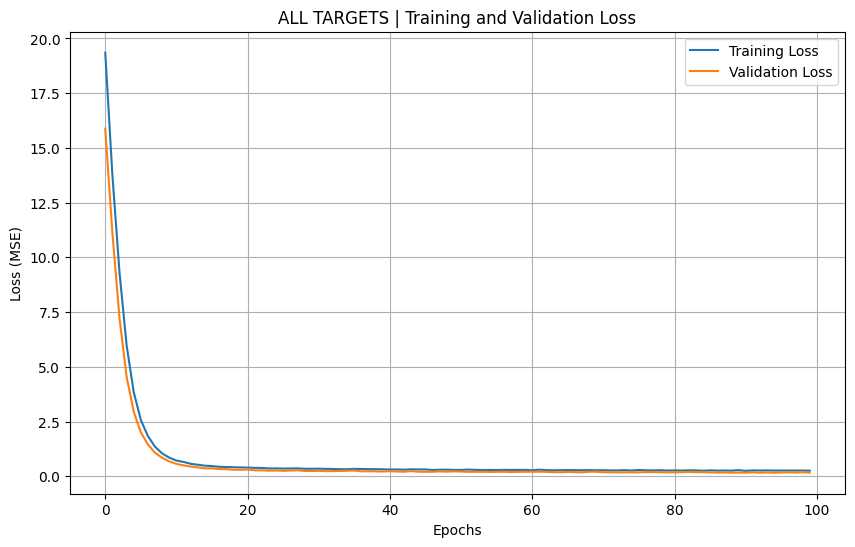

In [48]:
# Plot and log training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
# plt.title(f'{SELECTED_TARGET} | Training and Validation Loss')
plt.title(f'ALL TARGETS | Training and Validation Loss')
plt.legend()
plt.grid(True)
# plt.savefig(f"{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_training_history_r2_{test_r2:.4f}.png")
plt.show()

    # Log the training history plot as an artifact
    # mlflow.log_artifact(f"{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_training_history.png")

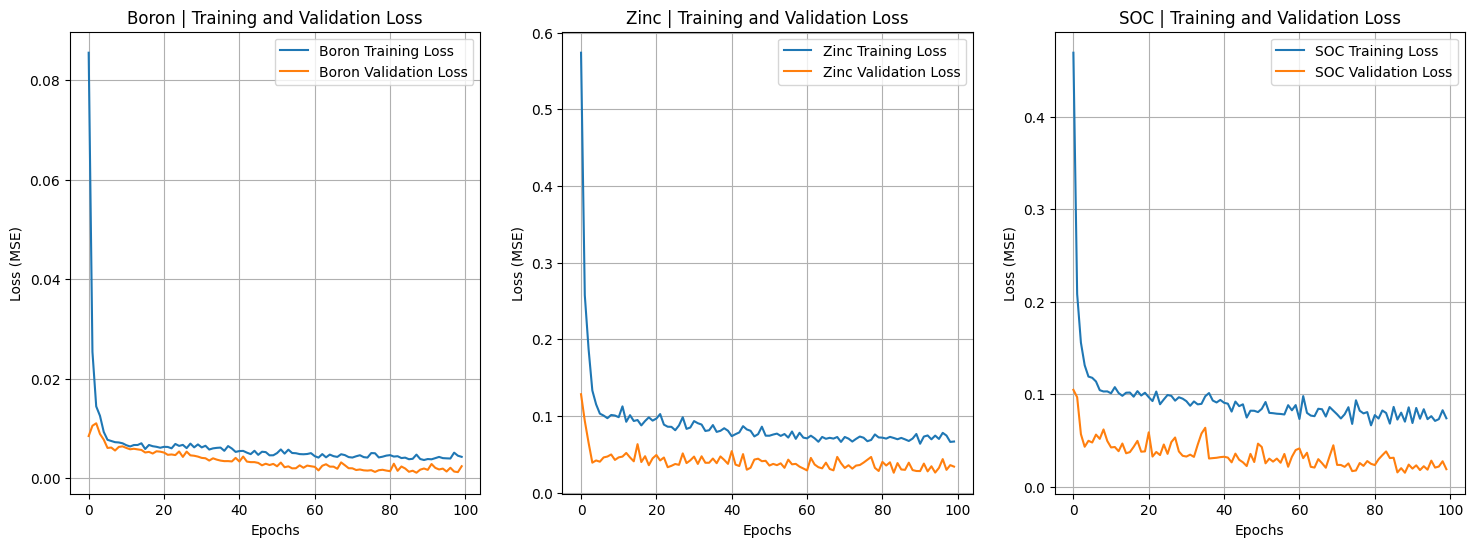

In [50]:
# Plot and log training history
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes = axes.flatten()

for i, target in enumerate(targets):
    axes[i].plot(history.history[f'{target}_loss'], label=f'{target} Training Loss')
    axes[i].plot(history.history[f'val_{target}_loss'], label=f'{target} Validation Loss')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss (MSE)')
    axes[i].set_title(f'{target} | Training and Validation Loss')
    axes[i].legend()
    axes[i].grid(True)

# plt.savefig(f"{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_training_history_r2_{test_r2:.4f}.png")
plt.show()